# Lab 4: Data Imputation using an Autoencoder

**Deadline**: Mon, Mar 07, 5:00pm

**Late Penalty**:  Any work that is submitted between 0 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**TA**: Shiva Akbari <shiva.akbari@mail.utoronto.ca>

In this lab, you will build and train an autoencoder to impute (or "fill in") missing data. 

We will be using the
Adult Data Set provided by the UCI Machine Learning Repository [1], available 
at https://archive.ics.uci.edu/ml/datasets/adult.
The data set contains census record files of adults, including their
age, martial status, the type of work they do, and other features. 

Normally, people use this data set to build a supervised classification
model to classify whether a person is a high income earner.
We will not use the dataset for this original intended purpose.

Instead, we will perform the task of imputing (or "filling in") missing values in the dataset. For example,
we may be missing one person's martial status, and another person's age, and
a third person's level of education. Our model will predict the missing features 
based on the information that we do have about each person.

We will use a variation of a denoising autoencoder to solve this data imputation
problem. Our autoencoder will be trained using inputs that have one categorical feature artificially
removed, and the goal of the autoencoder is to correctly reconstruct all features,
including the one removed from the input.

In the process, you are expected to learn to:

1. Clean and process continuous and categorical data for machine learning.
2. Implement an autoencoder that takes continuous and categorical (one-hot) inputs.
3. Tune the hyperparameters of an autoencoder.
4. Use baseline models to help interpret model performance.

[1] Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.


### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information (.html files are also acceptable).

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.


## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://drive.google.com/file/d/1ZBTOzlL3gcCQtAU98Ul98NsYNmy-2Pwk/view?usp=sharing 

In [51]:
import csv
import numpy as np
import random
import torch
import torch.utils.data
import time
import matplotlib.pyplot as plt

## Part 0

We will be using a package called `pandas` for this assignment. 

If you are using Colab, `pandas` should already be available.
If you are using your own computer,
installation instructions for `pandas` are available here: 
https://pandas.pydata.org/pandas-docs/stable/install.html

In [2]:
import pandas as pd

# Part 1. Data Cleaning [15 pt]

The adult.data file is available at `https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data`

The function `pd.read_csv` loads the adult.data file into a pandas dataframe.
You can read about the pandas documentation for `pd.read_csv` at
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [3]:
header = ['age', 'work', 'fnlwgt', 'edu', 'yredu', 'marriage', 'occupation',
 'relationship', 'race', 'sex', 'capgain', 'caploss', 'workhr', 'country']
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    names=header,
    index_col=False)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return func(*args, **kwargs)


In [4]:
df.shape # there are 32561 rows (records) in the data frame, and 14 columns (features)

(32561, 14)

### Part (a) Continuous Features [3 pt]

For each of the columns `["age", "yredu", "capgain", "caploss", "workhr"]`, report the minimum, maximum, and average value across the dataset. 

Then, normalize each of the features `["age", "yredu", "capgain", "caploss", "workhr"]`
so that their values are always between 0 and 1.
Make sure that you are actually modifying the dataframe `df`. 

Like numpy arrays and torch tensors, 
pandas data frames can be sliced. For example, we can
display the first 3 rows of the data frame (3 records) below.

In [5]:
df[:3] # show the first 3 records

,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States


Alternatively, we can slice based on column names, 
for example `df["race"]`, `df["hr"]`, or even index multiple columns 
like below.

In [6]:
subdf = df[["age", "yredu", "capgain", "caploss", "workhr"]]
subdf[:3] # show the first 3 records

,age,yredu,capgain,caploss,workhr
0,39,13,2174,0,40
1,50,13,0,0,13
2,38,9,0,0,40


Numpy works nicely with pandas, like below:

In [7]:
np.sum(subdf["caploss"])

2842700

Just like numpy arrays, you can modify
entire columns of data rather than one scalar element at a time.
For example, the code  

`df["age"] = df["age"] + 1` 

would increment everyone's age by 1.

In [8]:
print("minimum:")
subdf.min()

minimum:


age        17
yredu       1
capgain     0
caploss     0
workhr      1
dtype: int64

In [9]:
print("maximum:")
subdf.max()

maximum:


age           90
yredu         16
capgain    99999
caploss     4356
workhr        99
dtype: int64

In [10]:
print("average:")
subdf.mean()

average:


age          38.581647
yredu        10.080679
capgain    1077.648844
caploss      87.303830
workhr       40.437456
dtype: float64

In [11]:
print("normalize:")
df[["age", "yredu", "capgain", "caploss", "workhr"]] = (subdf - subdf.min())/(subdf.max() - subdf.min())
df[:3]

normalize:


,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,0.301370,State-gov,77516,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,83311,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.00000,0.0,0.122449,United-States
2,0.287671,Private,215646,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.00000,0.0,0.397959,United-States


### Part (b) Categorical Features [1 pt]

What percentage of people in our data set are male? Note that the data labels all have an unfortunate space in the beginning, e.g. " Male" instead of "Male".

What percentage of people in our data set are female?

In [12]:
# hint: you can do something like this in pandas
num_male = sum(df["sex"] == " Male")
num_female = sum(df["sex"] == " Female")
total = (df["sex"]).size

print("%.2lf percent are male, %.2lf percent are female" %(num_male*100/total, num_female*100/total))

66.92 percent are male, 33.08 percent are female


### Part (c) [2 pt]

Before proceeding, we will modify our data frame in a couple more ways:

1. We will restrict ourselves to using a subset of the features (to simplify our autoencoder)
2. We will remove any records (rows) already containing missing values, and store them in a second dataframe. We will only use records without missing values to train our autoencoder.

Both of these steps are done for you, below.

How many records contained missing features? What percentage of records were removed?

In [13]:
contcols = ["age", "yredu", "capgain", "caploss", "workhr"]
catcols = ["work", "marriage", "occupation", "edu", "relationship", "sex"]
features = contcols + catcols
df = df[features]

In [14]:
missing = pd.concat([df[c] == " ?" for c in catcols], axis=1).any(axis=1)
df_with_missing = df[missing]
df_not_missing = df[~missing]

In [15]:
missing = df_with_missing.shape[0]
total = df.shape[0]
print(missing, "records contained missing features;", missing*100/total, "% of records were removed")

1843 records contained missing features; 5.660145572924664 % of records were removed


### Part (d) One-Hot Encoding [1 pt]

What are all the possible values of the feature "work" in `df_not_missing`? You may find the Python function `set` useful.

In [16]:
values = set(df_not_missing["work"])
print("All possible values of the feature work in df_not_missing are:")
for i in values:
    print(i)

All possible values of the feature work in df_not_missing are:
 Federal-gov
 Local-gov
 Self-emp-not-inc
 Self-emp-inc
 Private
 State-gov
 Without-pay


We will be using a one-hot encoding to represent each of the categorical variables.
Our autoencoder will be trained using these one-hot encodings.

We will use the pandas function `get_dummies` to produce one-hot encodings
for all of the categorical variables in `df_not_missing`. 

In [17]:
data = pd.get_dummies(df_not_missing)

In [98]:
data[:5]

,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,...,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.301370,0.800000,0.02174,0.0,0.397959,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,0.452055,0.800000,0.00000,0.0,0.122449,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
2,0.287671,0.533333,0.00000,0.0,0.397959,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
3,0.493151,0.400000,0.00000,0.0,0.397959,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
4,0.150685,0.800000,0.00000,0.0,0.397959,0,0,1,0,0,...,0,0,0,0,0,0,0,1,1,0


### Part (e) One-Hot Encoding [2 pt]

The dataframe `data` contains the cleaned and normalized data that we will use to train our denoising autoencoder.

How many **columns** (features) are in the dataframe `data`?

Briefly explain where that number come from.

In [19]:
print("there are", data.shape[1], "features in datafram data")

there are 57 features in datafram data


The 57 comes from the number of continuous features and all possible value of each categorical features.

### Part (f) One-Hot Conversion [3 pt]

We will convert the pandas data frame `data` into numpy, so that
it can be further converted into a PyTorch tensor.
However, in doing so, we lose the column label information that
a panda data frame automatically stores.

Complete the function `get_categorical_value` that will return
the named value of a feature given a one-hot embedding.
You may find the global variables `cat_index` and `cat_values`
useful. (Display them and figure out what they are first.)

We will need this function in the next part of the lab
to interpret our autoencoder outputs. So, the input
to our function `get_categorical_values` might not 
actually be "one-hot" -- the input may instead 
contain real-valued predictions from our neural network.

In [20]:
datanp = data.values.astype(np.float32)

In [47]:
cat_index = {}  # Mapping of feature -> start index of feature in a record
cat_values = {} # Mapping of feature -> list of categorical values the feature can take

# build up the cat_index and cat_values dictionary
for i, header in enumerate(data.keys()):
    if "_" in header: # categorical header
        feature, value = header.split()
        feature = feature[:-1] # remove the last char; it is always an underscore
        if feature not in cat_index:
            cat_index[feature] = i
            cat_values[feature] = [value]
        else:
            cat_values[feature].append(value)

def get_onehot(record, feature):
    """
    Return the portion of `record` that is the one-hot encoding
    of `feature`. For example, since the feature "work" is stored
    in the indices [5:12] in each record, calling `get_range(record, "work")`
    is equivalent to accessing `record[5:12]`.
    
    Args:
        - record: a numpy array representing one record, formatted
                  the same way as a row in `data.np`
        - feature: a string, should be an element of `catcols`
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    return record[start_index:stop_index]

def get_categorical_value(onehot, feature):
    """
    Return the categorical value name of a feature given
    a one-hot vector representing the feature.
    
    Args:
        - onehot: a numpy array one-hot representation of the feature
        - feature: a string, should be an element of `catcols`
        
    Examples:
    
    >>> get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")
    'State-gov'
    >>> get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")
    'Private'
    """
    # <----- TODO: WRITE YOUR CODE HERE ----->
    # You may find the variables `cat_index` and `cat_values` 
    # (created above) useful.
    idx = np.argmax(onehot)
    return cat_values[feature][idx]

In [33]:
get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")

'State-gov'

In [34]:
get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")

'Private'

In [27]:
cat_index

{'edu': 33,
 'marriage': 12,
 'occupation': 19,
 'relationship': 49,
 'sex': 55,
 'work': 5}

In [29]:
cat_values

{'edu': ['10th',
  '11th',
  '12th',
  '1st-4th',
  '5th-6th',
  '7th-8th',
  '9th',
  'Assoc-acdm',
  'Assoc-voc',
  'Bachelors',
  'Doctorate',
  'HS-grad',
  'Masters',
  'Preschool',
  'Prof-school',
  'Some-college'],
 'marriage': ['Divorced',
  'Married-AF-spouse',
  'Married-civ-spouse',
  'Married-spouse-absent',
  'Never-married',
  'Separated',
  'Widowed'],
 'occupation': ['Adm-clerical',
  'Armed-Forces',
  'Craft-repair',
  'Exec-managerial',
  'Farming-fishing',
  'Handlers-cleaners',
  'Machine-op-inspct',
  'Other-service',
  'Priv-house-serv',
  'Prof-specialty',
  'Protective-serv',
  'Sales',
  'Tech-support',
  'Transport-moving'],
 'relationship': ['Husband',
  'Not-in-family',
  'Other-relative',
  'Own-child',
  'Unmarried',
  'Wife'],
 'sex': ['Female', 'Male'],
 'work': ['Federal-gov',
  'Local-gov',
  'Private',
  'Self-emp-inc',
  'Self-emp-not-inc',
  'State-gov',
  'Without-pay']}

In [35]:
# more useful code, used during training, that depends on the function
# you write above

def get_feature(record, feature):
    """
    Return the categorical feature value of a record
    """
    onehot = get_onehot(record, feature)
    return get_categorical_value(onehot, feature)

def get_features(record):
    """
    Return a dictionary of all categorical feature values of a record
    """
    return { f: get_feature(record, f) for f in catcols }

### Part (g) Train/Test Split [3 pt]

Randomly split the data into approximately 70% training, 15% validation and 15% test.

Report the number of items in your training, validation, and test set.

In [99]:
# set the numpy seed for reproducibility
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.seed.html
np.random.seed(50)
# todo
np.random.shuffle(datanp)

train_idx = int(len(datanp) * 0.7)
val_idx = int(len(datanp) * 0.85)
train_data = datanp[:train_idx]
val_data = datanp[train_idx : val_idx]
test_data = datanp[val_idx:]

print("number of training data:", train_data.shape[0])
print("number of validation data:", val_data.shape[0])
print("number of test data:", test_data.shape[0])


number of training data: 21502
number of validation data: 4608
number of test data: 4608


## Part 2. Model Setup [5 pt]

### Part (a) [4 pt]

Design a fully-connected autoencoder by modifying the `encoder` and `decoder`
below.

The input to this autoencoder will be the features of the `data`, with
one categorical feature recorded as "missing". The output of the autoencoder
should be the reconstruction of the same features, but with the missing
value filled in.

**Note**: Do not reduce the dimensionality of the input too much!
The output of your embedding is expected to contain information 
about ~11 features.

In [66]:
from torch import nn

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.name=AutoEncoder
        encoding_dim = 32
        self.encoder = nn.Sequential(
            nn.Linear(57, encoding_dim) # TODO -- FILL OUT THE CODE HERE!

        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 57), # TODO -- FILL OUT THE CODE HERE!
            nn.Sigmoid() # get to the range (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Part (b) [1 pt]

Explain why there is a sigmoid activation in the last step of the decoder.

(**Note**: the values inside the data frame `data` and the training code in Part 3 might be helpful.)

The sigmoid activation is used to scale the value of output data in the range between 0 and 1, since the data in the data frame are all between 0 and 1.

## Part 3. Training [18] 

### Part (a) [6 pt]

We will train our autoencoder in the following way:

- In each iteration, we will hide one of the categorical features using the `zero_out_random_features` function
- We will pass the data with one missing feature through the autoencoder, and obtain a reconstruction
- We will check how close the reconstruction is compared to the original data -- including the value of the missing feature

Complete the code to train the autoencoder, and plot the training and validation loss every few iterations.
You may also want to plot training and validation "accuracy" every few iterations, as we will define in
part (b). You may also want to checkpoint your model every few iterations or epochs.

Use `nn.MSELoss()` as your loss function. (Side note: you might recognize that this loss function is not
ideal for this problem, but we will use it anyway.)

In [73]:
def zero_out_feature(records, feature):
    """ Set the feature missing in records, by setting the appropriate
    columns of records to 0
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    records[:, start_index:stop_index] = 0
    return records

def zero_out_random_feature(records):
    """ Set one random feature missing in records, by setting the 
    appropriate columns of records to 0
    """
    return zero_out_feature(records, random.choice(catcols))

def get_val_loss(model, valid_loader, criterion):
    val_loss = 0.0
    itr = 0
    for data in valid_loader:
        datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
        recon = model(datam)
        loss = criterion(recon, data)
        val_loss += loss.item()
        itr += 1
    return float(val_loss)/itr

def get_model_name(name, epoch, lr):
    path = "model_{0}_epoch{1}lr{2}".format(name, epoch, lr)
    return path

def train(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-4):
    """ Training loop. You should update this."""
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []
    epochs = []

    start_time = time.time()

    for epoch in range(num_epochs):
        itr = 0
        total_train_loss = 0.0
        for data in train_loader:
            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(datam)
            loss = criterion(recon, data)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            #calculate the statistics
            total_train_loss += loss.item()
            itr += 1

        epochs.append(epoch)
        train_loss.append(float(total_train_loss)/itr)
        val_loss.append(get_val_loss(model, valid_loader, criterion))
        train_acc.append(get_accuracy(model, train_loader))
        val_acc.append(get_accuracy(model, valid_loader))
        #print('Epoch:{}, Training Loss:{:.4f}, Validation Loss:{:.4f}'.format(epoch+1, train_loss[-1], val_loss[-1]))
        model_path = get_model_name(model.name, epoch, learning_rate)
        torch.save(model.state_dict(), model_path)
    
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("total time takes:", elapsed_time)

    '''
    np.savetxt("{}_train_acc.csv".format(model_path), train_acc)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_acc.csv".format(model_path), val_acc)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)
    '''
    #plot
    plt.title("Train/Validation Loss")
    plt.plot(epochs, train_loss, label="Train")
    plt.plot(epochs, val_loss, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Train/Validation Accuracy")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, val_acc, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

### Part (b) [3 pt]

While plotting training and validation loss is valuable, loss values are harder to compare
than accuracy percentages. It would be nice to have a measure of "accuracy" in this problem.

Since we will only be imputing missing categorical values, we will define an accuracy measure.
For each record and for each categorical feature, we determine whether
the model can predict the categorical feature given all the other features of the record.

A function `get_accuracy` is written for you. It is up to you to figure out how to
use the function. **You don't need to submit anything in this part.**
To earn the marks, correctly plot the training and validation accuracy every few 
iterations as part of your training curve.

In [26]:
def get_accuracy(model, data_loader):
    """Return the "accuracy" of the autoencoder model across a data set.
    That is, for each record and for each categorical feature, 
    we determine whether the model can successfully predict the value
    of the categorical feature given all the other features of the 
    record. The returned "accuracy" measure is the percentage of times 
    that our model is successful.
        
    Args:
       - model: the autoencoder model, an instance of nn.Module
       - data_loader: an instance of torch.utils.data.DataLoader

    Example (to illustrate how get_accuracy is intended to be called.
             Depending on your variable naming this code might require
             modification.)

        >>> model = AutoEncoder()
        >>> vdl = torch.utils.data.DataLoader(data_valid, batch_size=256, shuffle=True)
        >>> get_accuracy(model, vdl)
    """
    total = 0
    acc = 0
    for col in catcols:
        for item in data_loader: # minibatches
            inp = item.detach().numpy()
            out = model(zero_out_feature(item.clone(), col)).detach().numpy()
            for i in range(out.shape[0]): # record in minibatch
                acc += int(get_feature(out[i], col) == get_feature(inp[i], col))
                total += 1
    return acc / total

Training crve plotting see next part

### Part (c) [4 pt]

Run your updated training code, using reasonable initial hyperparameters.

Include your training curve in your submission.

Epoch:1, Training Loss:0.2145, Validation Loss:0.1701
Epoch:2, Training Loss:0.1239, Validation Loss:0.0916
Epoch:3, Training Loss:0.0802, Validation Loss:0.0733
Epoch:4, Training Loss:0.0698, Validation Loss:0.0671
Epoch:5, Training Loss:0.0648, Validation Loss:0.0627
Epoch:6, Training Loss:0.0607, Validation Loss:0.0589
Epoch:7, Training Loss:0.0571, Validation Loss:0.0556
Epoch:8, Training Loss:0.0539, Validation Loss:0.0526
Epoch:9, Training Loss:0.0510, Validation Loss:0.0495
Epoch:10, Training Loss:0.0481, Validation Loss:0.0468
Epoch:11, Training Loss:0.0455, Validation Loss:0.0441
Epoch:12, Training Loss:0.0428, Validation Loss:0.0415
Epoch:13, Training Loss:0.0402, Validation Loss:0.0392
Epoch:14, Training Loss:0.0380, Validation Loss:0.0369
Epoch:15, Training Loss:0.0358, Validation Loss:0.0348
Epoch:16, Training Loss:0.0338, Validation Loss:0.0329
Epoch:17, Training Loss:0.0319, Validation Loss:0.0311
Epoch:18, Training Loss:0.0302, Validation Loss:0.0296
Epoch:19, Training 

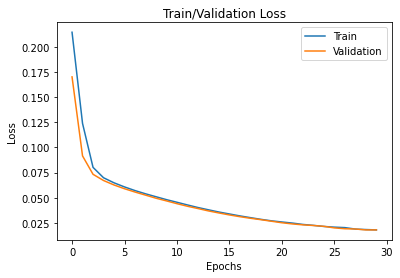

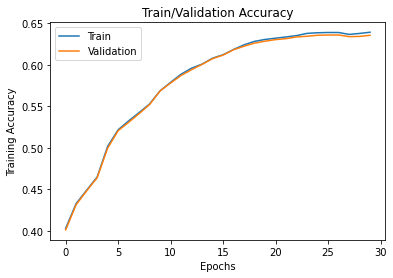

In [70]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=True)

model = AutoEncoder()

train(model, train_loader, valid_loader, 30)

### Part (d) [5 pt]

Tune your hyperparameters, training at least 4 different models (4 sets of hyperparameters).

Do not include all your training curves. Instead, explain what hyperparameters
you tried, what their effect was, and what your thought process was as you 
chose the next set of hyperparameters to try.

Finished Training
total time takes: 68.74365782737732


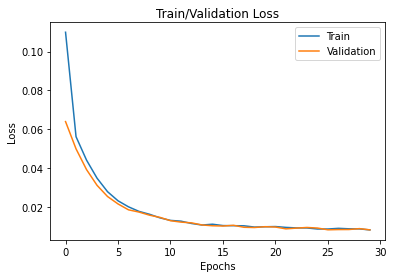

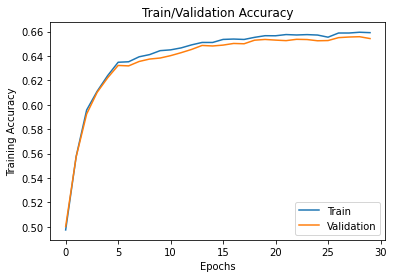

In [100]:
#base on the results from part c, the model is underfitting, so increase learning rate from 0.0001 to 0.0005
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=True)

model_1 = AutoEncoder()

train(model_1, train_loader, valid_loader, 30, 0.0005)

Finished Training
total time takes: 83.55692958831787


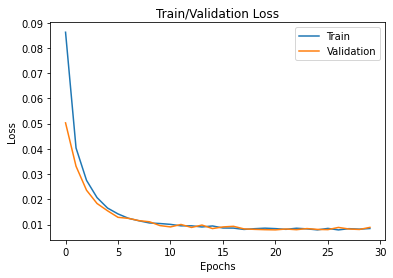

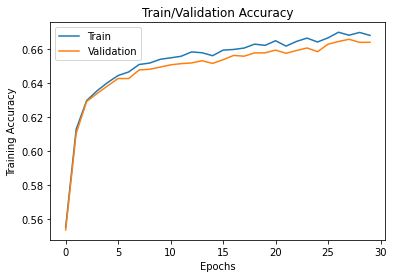

In [75]:
#model_1 is still underfitting, so increase learning rate from 0.0005 to 0.001
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=True)

model_2 = AutoEncoder()

train(model_2, train_loader, valid_loader, 30, 0.001)

Finished Training
total time takes: 130.04285550117493


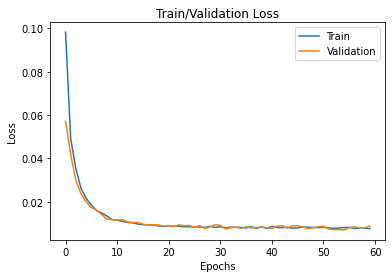

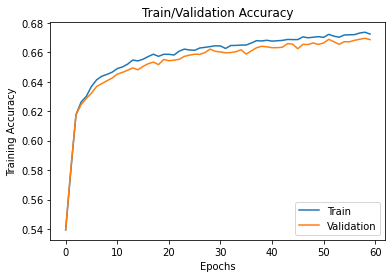

In [76]:
#the traning curve of model_2 is bit noise and still underfitting, so lower the learning rate from 0.001 to 0.0007 and increase number of epochs from 30 to 60
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=True)

model_3 = AutoEncoder()

train(model_3, train_loader, valid_loader, 60, 0.0007)

Finished Training
total time takes: 257.17588210105896


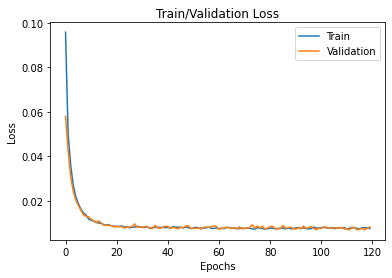

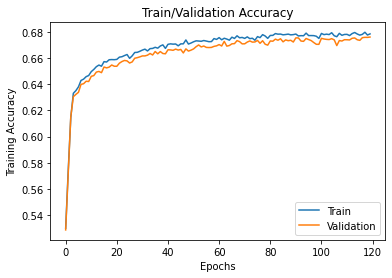

In [77]:
#the validation loss curve of model_3 is flatten, and does not shown a sign of overfitting, so increase learning rate from 60 to 120
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=True)

model_4 = AutoEncoder()

train(model_4, train_loader, valid_loader, 120, 0.0007)

Finished Training
total time takes: 517.8275935649872


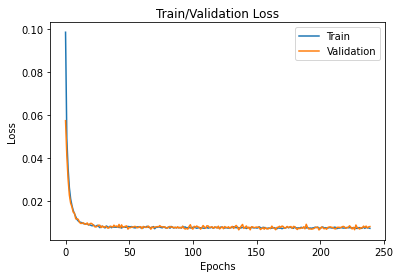

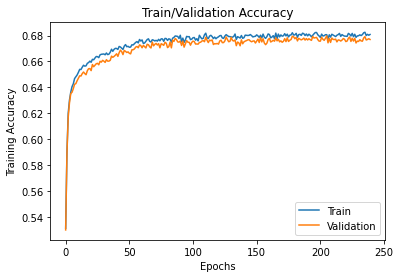

In [78]:
#the validation loss curve of model_4 is flatten, and does not shown a sign of overfitting, so increase learning rate from 120 to 240
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=True)

model_5 = AutoEncoder()

train(model_5, train_loader, valid_loader, 240, 0.0007)

Finished Training
total time takes: 1150.7589507102966


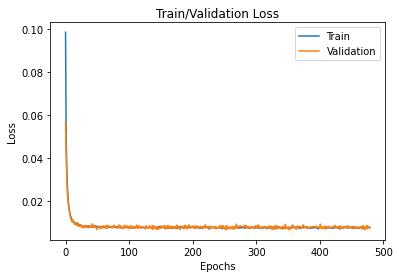

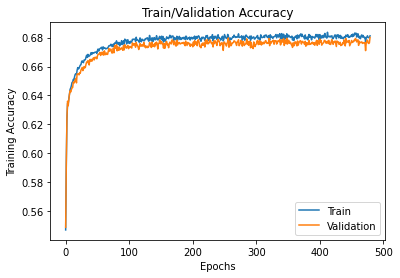

In [79]:
#the validation loss curve of model_5 is flatten, and does not shown a sign of overfitting, so increase epochs from 240 to 480
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=True)

model_6 = AutoEncoder()

train(model_6, train_loader, valid_loader, 480, 0.0007)

Conclusion: as we can see from the above 6 models, the highest validation accuracy it can achieve is around 67%. Model_4 takes relative less time so we will use model_4 in the next part for testing.

## Part 4. Testing [12 pt]

### Part (a) [2 pt]

Compute and report the test accuracy.

In [102]:
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)
test_acc = get_accuracy(model_5, test_loader)
print("The test accuracy of the best model is", test_acc*100, "%")

The test accuracy of the best model is 68.29065393518519 %


### Part (b) [4 pt]

Based on the test accuracy alone, it is difficult to assess whether our model
is actually performing well. We don't know whether a high accuracy is due to
the simplicity of the problem, or if a poor accuracy is a result of the inherent
difficulty of the problem.

It is therefore very important to be able to compare our model to at least one
alternative. In particular, we consider a simple **baseline**
model that is not very computationally expensive. Our neural network
should at least outperform this baseline model. If our network is not much
better than the baseline, then it is not doing well.

For our data imputation problem, consider the following baseline model:
to predict a missing feature, the baseline model will look at the **most common value** of the feature in the training set. 

For example, if the feature "marriage" is missing, then this model's prediction will be the most common value for "marriage" in the training set, which happens to be "Married-civ-spouse".

What would be the test accuracy of this baseline model?


In [80]:
baseline = {}

#found the most common value for each col
for col in df_not_missing:
    baseline[col] = df[col].value_counts().idxmax()

acc = sum(df_not_missing["marriage"] == baseline["marriage"])/len(df_not_missing)
print("The baseline model accuracy is", acc*100, "%")

The baseline model accuracy of the "marriage" feature is 46.67947131974738 %


### Part (c) [1 pt]

How does your test accuracy from part (a) compared to your basline test accuracy in part (b)?

The test accuracy from part a is 68.3%, higher than the basline accuracy of 46.7%. This means that our model is performing well.

### Part (d) [1 pt]

Look at the first item in your test data. 
Do you think it is reasonable for a human
to be able to guess this person's education level
based on their other features? Explain.

In [84]:
get_features(test_data[0])

{'edu': 'HS-grad',
 'marriage': 'Never-married',
 'occupation': 'Machine-op-inspct',
 'relationship': 'Unmarried',
 'sex': 'Female',
 'work': 'Private'}

Based on the occupation, we are able to make resonable guess for a person's education level, since there is a relationship between education level and occupation. Usually good occupation results from the higher education.

### Part (e) [2 pt]

What is your model's prediction of this person's education
level, given their other features?


In [96]:
test = zero_out_feature(test_data[:1], "edu")[0]
predict = model_4(torch.from_numpy(test))
get_feature(predict.detach().numpy(), "edu")

'HS-grad'

### Part (f) [2 pt]

What is the baseline model's prediction
of this person's education level?

In [97]:
#Since the baseline always predicts the most common value, we get teh following results
baseline["edu"]

' HS-grad'

This prediction is actually correct. But it does not necessary mean it has the same performance as our trained model. More test case need to be used to evluate the basline model.